# Variational Autoencoder Tutorial

This tutorial is meant to serve as a walk-through behind the idea of variational autoencoders and what problem they are meant to solve. While this means that we will go through a complicated process to arrive at a simple neural architecture, I believe it's worth it.

## Background and motivation

 ### Reading
VAEs have been introduced originally in https://arxiv.org/pdf/1312.6114.pdf by Kingma and Welling

Now they are used, for example, in OpenAI's Dall-E image generation model (
https://github.com/openai/DALL-E/tree/master,https://arxiv.org/pdf/2102.12092.pdf) based on 
VQ-VAEs (https://proceedings.neurips.cc/paper/2019/file/5f8e2fa1718d1bbcadf1cd9c7a54fb8c-Paper.pdf)

A more technical (and also pedagogical) deep dive can be found in https://arxiv.org/pdf/1906.02691.pdf (written by original authors). 

NB: When looking for images, I realised that the Wikipedia article on Variational Autoencoders is in fact very good and pedagogical on the theory. So that would be a good sumary of the theory part of this tutorial.

### Theory

Let's say that we have a complicated and unknown probability distribution $P(X)$ over a random variable $X$ that we would like to sample from. To do this, we have a parametrized latent hidden variable model $P_\theta(X,Z)$ (we assume the choice of $Z$ to be fixed here), for which, by assumption, we can generate joint samples $(x,z)$ easily. Now, we would like to use an existing dataset of points $\mathbf{x} = (x_1, \dots, x_N)$ that we assume to be i.i.d. samples from $P$, in order to find 

$$
\theta^* := \arg \min_\theta D(P(X) \| P_\theta(X)),
$$

where $D$ is the KL-divergence and $P_\theta(X) = \int_z P_\theta(X, Z=z) dz$ is the marginal distribution over $X$. Using the definition of the KL-divergence, we can see that this is equivalent to maximizing the log-likelihood of the data, in the sense that 

$$
\theta^* = \arg \max_\theta \sum_{i=1}^N \log P_\theta(X_i = x_i),
$$

where $X_i$ denotes the random variable corresponding to the sampling event of the $i$th data point.

To be concrete, lets consider the case that the distribution we'd like to sample from are handwritten digits and that our training set is the MNIST dataset.

In [4]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [5]:
training_data = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())

test_data = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

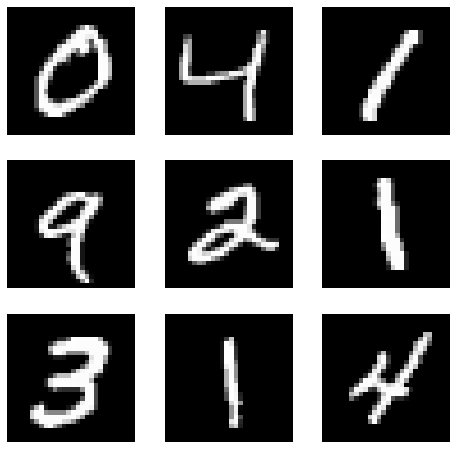

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = training_data[i]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Abstractly speaking then, $X$ is a random variable with sample space $[0,1]^{(28 \times 28)}$ and only a tiny subset of these points correspond to meaningful images of handwritten digits. 

Now, lets say that $P_\theta$ is a differentiable function of $\theta$. In this case the natural thing is to find $\theta^*$ by a gradient descent based method. In the course of this, we'd have to evaluate 

$$
\nabla_\theta \log P_\theta(X) = \frac{\nabla_\theta P_\theta(X)}{P_\theta(X)}.
$$

But this is often difficult to do, since in order to evaluate $P_\theta(X)$ (and also in practice the gradient of $P_\theta(X)$), we'd have to evaluate the integral over the latent variable $Z$. 

To see this, lets say that we assume a probabilistic model for the data generation, in which each data point $x_i$ is generated as follows: First, a hidden vector $z_i \sim P(z)$ is sampled from a *prior*. Then, $z_i$ is fed through a neural network, which results in an output vector $f_\theta(z_i)$. Finally, $x_i$ is sampled from a distribution $P(X|f_\theta(z_i)$, which is called the *likelihood*. Then, in order to calculate 

$$
P\theta(X=x) = \int_z P_\theta(X, Z=z) dz = \int_z P(X|f_\theta(z)) P(Z=z)dz
$$ 

explicitly for a given point $x$, we'd have to calculate $P(x|f_\theta(z))$ for all possible values of $z$. This is of course infeasible already in our small example. 

Instead, we could try to estimate the marginal probability by $\hat{P}_\theta(X=x) = \frac{1}{n} \sum_i P(X=x|f_\theta(z_i))$ by generating $n$ samples of $Z$ and calculating the probability only for these. However, the problem is that, the distributions $P(X|f_\theta(z))$ tend to be very sparse (for realistic values of $\theta$), which means that one usually would require a very large number of samples $n$ in order for the estimator to converge to the true value. 

To see this in an example, lets consider the special case in which $P(Z) = \mathcal{N}(0, \mathbb{1})$ in $d$ latent dimensions and that $P_\theta(X|z) = \mathcal{N}(f_\theta(z), \sigma^2 \mathbb{1})$. In this case, $P(x|z) \propto exp(- \|x - f_\theta(z)\|_2^2/\sigma^2)$. Moreover, since $\sigma^2$ tends to have to be very small, this means that there is only a very small region of values $f_\theta(z)$ that significantly contributes to the likelihood and hence, for functions $f_\theta$ with resonable Lipschitz continuity features, it also means that the there is only a small region in the latent space that contirbutes to it, so that under the normal prior usually

$$
P(z : \|x - f_\theta(z)\|_2^2 < \sigma^2 ) \propto exp(-d).
$$


## Solving the problem with Monte Carlo Expectation Maximization
(see https://www.lri.fr/~sebag/COURS/EM_algorithm.pdf for a reference of this part)

So, how can we estimate $P_\theta(x)$ in practice? Before the advent of variational inference algorithms (and still for smaller scale problems), people would have used Markov Chain Monte Carlo sampling to do so.

Here's the idea behind: While simply sampling from the prior will not yield estimates that converge quickly, if you could sample from the *posterior* distribution $P_\theta(Z|x)$ for a given data point $x$, you can use this to construct an algorithm that will allow you to find $\theta^*$. This algorithm is called the *expectation maximization* (EM) algorithm and here's how it works:

We set an initial value $\theta_0$. Then, in the *i*the iteration of the algorithm, we set 

$$
\theta_{i + 1} = \arg \max_\theta \mathbb{E}_{z \sim P_{\theta_i}(Z|x)} \log P_\theta(x, Z)
$$

Then, clever people have shown that, in general $\lim_{i \to \infty} \theta_i = \arg \max_\theta P_\theta(x)$. The same is true when we replace the individual data point $x$ with the whole dataset $\mathbf{x}$. In other words, the EM algorithm is not an algorithm to estimate the $P_\theta(x)$ of a single point, it instead uses sampling from the posterior distribution to solve the overall problem of learning the parameters $\theta$.

In practice, we'd again use $n$ samples $z_i$ from the posterior distribution to estimate the above expectation value as $\sum_i^n \log P_\theta(x, z_i)$, which is an expression that we *can* readily evaluate the gradient wrt $\theta$ of (to give us an estimate of the gradient), which we use to determine the steps we take in solving the maximization problem.

Now, you might ask: "Well, this is all nice in theory, but doesn't the EM algorithm suffer from the exact problem as the naive estimator above? Doesn't it take many samples of the posterior for the estimator to be close to the true value? The answer here: In general "No". This is because by Bayes theorem (a.k.a. by definition), we have
$$
P_\theta(Z|X) = \frac{P_\theta(X,Z)}{P_\theta(X)}.
$$
This means that, for fixed $\theta$, the posterior and the joint distribution are proportional to another. In our case, this means that samples from the posterior are naturally more likely where the function you want to estimate ($\log P(X,Z)$) is larger. Of course, in the above setting the posterior and the joint pdf carry different parameters, but for values of $\theta$ in the vicinity of $\theta_i$, the reasoning remains true, so that for small step sizes the estimators should converge quickly. 

In practice, people use MCMC samplers (such as the gradient based HMC or NUTS samplers) to run the EM algorithm

## Variational autoencoders

### Variational inference

Unfortunately, even this approach takes too long when the datasets become too large. Variational autoencoders are meant to address this. They make use of a technique known as *variational inferece*. In short, they attempt to bypass the MCMC steps required when sampling from the posterior, by instead learning a function $q_\phi$ that maps from the space of possible data points to *probability distributions over the latent variables*, in such a way that, for as many $x$ as possible, $q_\phi(x)$ is a good approximator of the posterior $P_\theta(z|x)$. The functions $q_\phi$ are chosen in such a way that sampling from them is always possible efficiently. The promise is that, if one can get this to work, one can replace estimates over the posterior (which are complicated to get for large data) with estimates under the approximate posterior (which is also called the *guide*).

In VAEs, the guide will be defined as a neural network (the "encoder"), often with outputs $\mu_\phi(x), \sigma_\phi(x)$ and then the approximate posterior will be a normal distribution over the latent space, i.e. 

$$
q_\phi(x) = \mathcal{N}(\mu_\phi(x), \sigma^2_\phi(x) \mathbb{1})
$$

See https://arxiv.org/pdf/1601.00670.pdf for a recent review

At this point the following picture starts to emerge (IGNORE THE "MINIMIZE DIFFERENCE", that's not the (total) loss function as we will see, only part of it):

![alt text](Variational-AutoEncoder-VAE-architecture.png "Title")

https://www.researchgate.net/figure/Variational-AutoEncoder-VAE-architecture_fig1_333573656

### The ELBO - A new objective 

Now, how exactly can we use variational inference and guides to solve our original problem, which was to obtain a MLE for our model? Recall that the problem was that we needed estimate the values of $P_\theta(x)$ in order to evaluate the gradients of the log-likelihood of the data. In variational autoencoders, a slightly different objective for which it turns out that 

1. the gradients *can* be efficiently estimated, and 
2. finding good parameters wrt this new objective entails finding good parameters wrt the original likelihood objective.

This new objective function is called the *Evidence Lower Bound Objective* (ELBO). In the following, let $q_\phi(z|x)$ denote that probability that $z$ will be sampled under $q_\phi(x)$. The ELBO is then defined as 

$$
\mathcal{L}_{\theta, \phi}(x) = \mathbb{E}_{z \sim q_\phi(x)}\left( \log P_\theta(x, z) - \log q_\phi(z|x) \right).
$$

It should not be obvious why this is a good function to optimize for. However, things become clearer once we note that we can rewrite this as 

$$
\mathcal{L}_{\theta, \phi}(x) = \log P_\theta(x) - D(q_\phi(x)\|P_\theta(Z|x)).
$$

The first term is the log-likelihood and the second term is the KL-divergence between the approximate posterior and the true postierior for $x$. We note two things here

1. By the positivity of the KL-divergence for probability distributions, it follows that the ELBO is always smaller than the log-likelihood. Since the log-likelihood of the marginal distribution $P(X)$ is also called the *evidence*, this explains the name of the ELBO.
2. Maximizing the ELBO (with respect to the whole dataset $\mathbf{x}$) over the parameters $\theta, \phi$ then is equivalent to maximizing the log-likelihood (our original objective) *and* fitting the approximate posterior to the real posterior. 

The overall idea then is that, using variational inference will be so much quicker than MCMC based methods that even if we optimize for an objective that isn't completely equivalent to the original objective, our ability to sample quickly from better and better approximate posteriors will overall buy us the time to overall reach a better value for the $\theta$ parameters as well. 

It remains to see how we can evaluate the gradients of ELBO wrt the parameters, and then, of course, how to implement it in code. 

### Estimating gradients and the reparametrization trick

In order to run stochastic gradient descent for train the parameters, with the ELBO as a loss function, we need to estimate the gradients of the ELBO. For $\theta$, this turns out to be simple:

$$
\begin{align}
\nabla_\theta \mathcal{L}_{\theta, \phi}(x) &= \nabla_\theta \mathbb{E}_{z \sim q_\phi(x)}\left( \log P_\theta(x, z) - \log q_\phi(z|x) \right) \\
&=  \mathbb{E}_{z \sim q_\phi(x)}\nabla_\theta \left( \log P_\theta(x, z) - \log q_\phi(z|x) \right)\\
&\simeq \frac{1}{L}\sum_j^L \nabla_\theta \log P_\theta(x, z_i)
\end{align}
$$

But for $\phi$, this is more complicated, since 

$$
\begin{align}
\nabla_\phi \mathcal{L}_{\theta, \phi}(x) &= \nabla_\phi \mathbb{E}_{z \sim q_\phi(x)}\left( \log P_\theta(x, z) - \log q_\phi(z|x) \right) \\
&\neq  \mathbb{E}_{z \sim q_\phi(x)}\nabla_\phi \left( \log P_\theta(x, z) - \log q_\phi(z|x) \right)\\
&= -\frac{1}{L}\sum_j^L \nabla_\phi \log q_\phi(z|x)
\end{align}
$$

This mathematical problem is also reflected in a technical propblem, regarding how gradient descent via backpropagation works: The sampling of the latent variables at the bottleneck "interrupts" the backpropagation process, since there is no deterministic, differentiable functional relation between the encoding and decoding layers anymore.

#### Reparametrization trick

This is where the reparametrization trick comes in: The idea is to "outsource" the randomness to not interrupt the flow. This might sound impossible, but it's actually quite simple:

We define a function $g(\epsilon, \phi, x)$ that depends on some other random variable $\epsilon$ such that $g(\epsilon, \phi, x) \simeq q_\phi(z|x)$, i.e. the resulting distributions coincide. We can then simply set $z = g(\epsilon, \phi, x)$. Because of this trick, we now have 

$$
\begin{align}
\nabla_\phi \mathcal{L}_{\theta, \phi}(x) &= \nabla_\phi \mathbb{E}_{z \sim q_\phi(x)}\left( \log P_\theta(x, z) - \log q_\phi(z|x) \right) \\
&= \nabla_\phi \mathbb{E}_{P(\epsilon)}\left( \log P_\theta(x, g(\phi, \epsilon, x)) - \log q_\phi(g(\phi, \epsilon, x)|x) \right) \\
&= \mathbb{E}_{P(\epsilon)} \nabla_\phi \left( \log P_\theta(x, g(\phi, \epsilon, x)) - \log q_\phi(g(\phi, \epsilon, x)|x) \right) \\
&\simeq -\frac{1}{L}\sum_j^L \nabla_\phi \left( \log P_\theta(x, g(\phi, \epsilon_i, x)) - \log q_\phi(g(\phi, \epsilon_i, x)|x) \right) \\
\end{align}
$$

![](Reparameterized_Variational_Autoencoder.jpg)

https://en.wikipedia.org/wiki/Variational_autoencoder

![Screenshot from original paper](reparam.png)

(Screenshot from original paper)

Now, finally everything is in place: We can implement a VAE in pytorch, using Stochastic Gradient Descent. The combination of Stochastic Gradient Descent with Variational Inference is also called *Stochastic Variational Inference*

# Implementing a VAE on Mnist in Pytorch

The above is all very abstract: For our implementation, we will use simple neural networks for both encoder and decoder, with a latent variable dimension of 20. We aim at having a multivariate Gaussian distribution for the guide, which is why we split the output layers of the decoder into a mean and a variance layer.

![](layerdetails.png)

https://www.jeremyjordan.me/variational-autoencoders/

In [21]:
# Code taken and slightly from https://github.com/geyang/variational_autoencoder_pytorch

import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, hidden_n_1=20, hidden_n_2=400):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_n_1, hidden_n_2)
        self.fc2 = nn.Linear(hidden_n_2, 784)

        self.reLU = nn.ReLU() 
        self.sigmoid = nn.Sigmoid()

    def forward(self, embedded):
        h1 = self.reLU(self.fc1(embedded))
        return self.sigmoid(self.fc2(h1))


class Encoder(nn.Module):
    def __init__(self, hidden_n_1=400, hidden_n_2=20):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, hidden_n_1)
        self.fc_mu = nn.Linear(hidden_n_1, hidden_n_2)
        self.fc_var = nn.Linear(hidden_n_1, hidden_n_2)

    def forward(self, x):
        h1 = self.fc1(x)
        return self.fc_mu(h1), self.fc_var(h1)

To build the full VAE, we need to add the sampling (and also reparametrization) logic to the networks. 

In [22]:
from torch.autograd import Variable

class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_n=20):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = Encoder(hidden_n_2=latent_n)
        self.decoder = Decoder(hidden_n_1=latent_n)

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

    def reparameterize(self, mu, log_var):
        """you generate a random distribution w.r.t. the mu and log_var from the embedding space.
        In order for the back-propagation to work, we need to be able to calculate the gradient. 
        This reparameterization trick first generates a normal distribution, then shapes the distribution
        with the mu and variance from the encoder.
        
        This way, we can can calculate the gradient parameterized by this particular random instance.
        """
        vector_size = log_var.size()
        eps = Variable(torch.FloatTensor(vector_size).normal_())
        std = log_var.mul(0.5).exp_()
        return eps.mul(std).add_(mu)

In order to train the VAE, we now need to implement the estimation of the ELBO for our particular choice of distributions. Now, when choosing the gaussian guide as we did, it turns out that we can analytically go a long way and estimate the gradient as shown in the formula below, where $J$ is the dimension of the latent space and $L$ is the number of latent samples (which we set to 1 in our training).

![](estimator.png)

In [91]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.bce_loss = nn.BCELoss(reduction='sum')
#         self.bce_loss.size_average = False

    def forward(self, x, mu, log_var, recon_x):
        """gives the batch normalized Variational Error."""

        batch_size = x.size()[0]
        BCE = self.bce_loss(recon_x, x.view(-1, 784))

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD_element = mu.pow(2).add_(log_var.exp()).mul_(-1).add_(1).add_(log_var)
        KLD = torch.sum(KLD_element).mul_(-0.5)

        return (BCE + KLD) / batch_size


Why is the $\log P_\theta(x|\hat{z})$ term in the ELBO estimate calculated with the BCE loss? As set, the `nn.BCELoss(x,y)` for two tensors of size $M$ will calculate 

$$
-\sum_i^M x_i \log(y_i) + (1 - x_i)\log(y_i)
$$

Now, what is the Bernoulli output probability? For every pixel $i$, it's $P(X_i = x_i) = p_i^{x_i}(1-p_i)^{1-x_i}$. So $\log P_\mathbf{p}(x) = \sum_i^M p_i \log(x_i) + (1 - p_i)\log(x_i)$ is exactly the (negative of) the BCELoss, since I input not the sampeld image but the output of the sigmoid function, which are just the Bernoulli parameters. (NB: In Pytorch, the loss function is minimized, hence we need to implement the loss function as the negative of the ELBO. This is done on line 18 above for the KLD term (extra factor of -1) and the BCE term is already the negative of the log likelihood)

In [94]:
import numpy as np
import torch.utils.data
import torch.optim as optim
from torchvision import transforms
import os

class Session():
    def __init__(self, model, is_cuda=False,
                 train_step_init=0, lr=1e-3, prefix="Variational_Autoencoder",
                 dashboard_server=False,
                 checkpoint_path=None, load=False, save=False):
        self.prefix = prefix
        self.train_step = train_step_init
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.loss_fn = VAELoss()
        self.epoch_number = 0

    def train(self, loader, epoch_number=None, verbose=True, report_interval=100):
        if epoch_number is not None:
            self.epoch_number = epoch_number

        # built-in method for the nn.module, sets a training flag.
        self.model.train()
        losses = []
        for batch_idx, (data, _) in enumerate(loader):
            data = Variable(data)
            self.optimizer.zero_grad()
            recon_batch, mu, log_var = self.model(data)
            loss = self.loss_fn(data, mu, log_var, recon_batch)
            loss.backward()
            
            self.optimizer.step()
            self.train_step += 1
            loss_data = loss.data.numpy()
            losses.append(loss_data)

            if verbose and batch_idx % report_interval == 0:
                print('batch loss is: {:.4}'.format(np.mean(losses)/data.size()[0]))

        self.epoch_number += 1
        return losses

    def test(self, test_loader):
        # nn.Module method, sets the training flag to False
        self.model.eval()
        test_loss = 0
        for batch_idx, (data, _) in enumerate(test_loader):
            data = Variable(data) #volatile=True)
            recon_batch, mu, logvar = self.model(data)
            test_loss += self.loss_fn(data, mu, logvar, recon_batch).data.numpy()

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
# the main training loop

EPOCHS = 20
BATCH_SIZE = 128
REPORT_INTERVAL = 100

train_loader = torch.utils.data.DataLoader(
    training_data, batch_size=BATCH_SIZE, shuffle=True, **{})

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=True, **{})

losses = []
vae = VariationalAutoEncoder()
sess = Session(vae, lr=1e-3)
for epoch in range(1, EPOCHS + 1):
    losses += sess.train(train_loader, epoch, REPORT_INTERVAL)
    print('epoch {} complete'.format(epoch))
    sess.test(test_loader)

In [ ]:
# to sample images, we sample from the prior (which we take to be a standard normal distribution) 
# and then use the output from the decoder as the output image (which we can interpret as the mean of)
# taking many samples

def generate_images(vae):
    row, col = 5,5
    latent_dim = vae.encoder.fc_mu.out_features
    z = Variable(torch.FloatTensor(25,latent_dim).normal_())
#     z = Variable(torch.randn(row * col, latent_dim))
    x = vae.decoder(z)
    fig = plt.figure(figsize=(15, 15))
    for n in range(row * col):
        ax = plt.subplot(row, col, n + 1)
        ax.imshow(x[n].view(28, 28).data.numpy(), cmap='gray', aspect='auto')

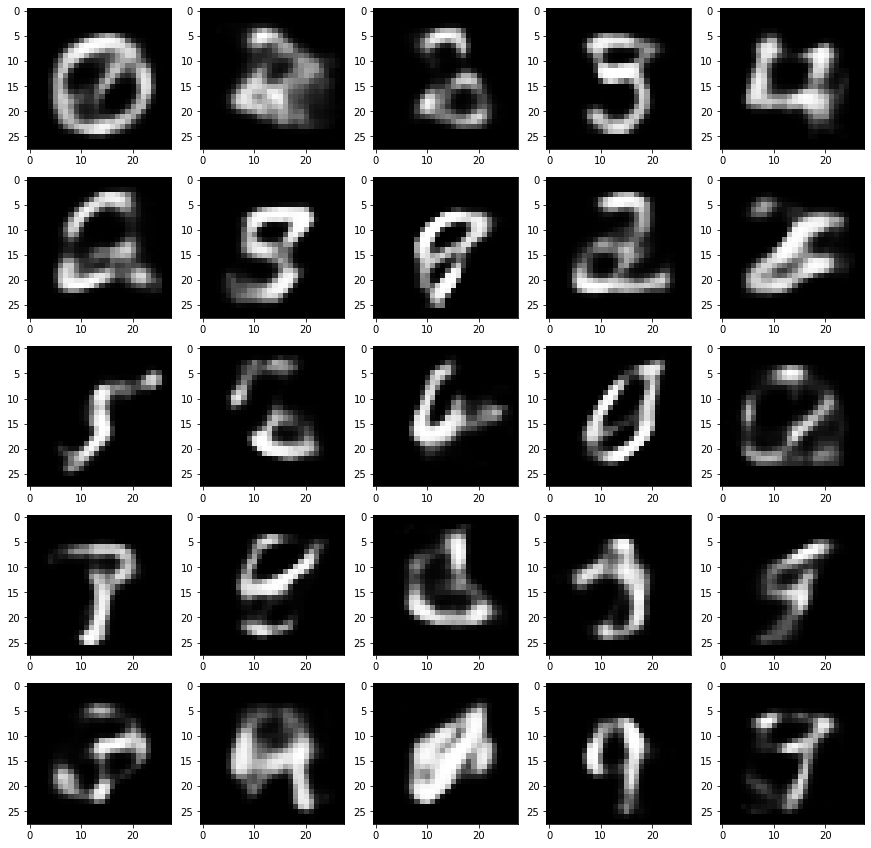

In [93]:
generate_images(vae)

As we can see, this image doesn't work so well. I'm not sure why that is but I double-checked with the original repo (which is 5 years old), and it has the same problem.

## Training a variational auto-encoder with Pyro

Pyro is a framework for probabilistic programming written on top of Pytorch. It facilitates implementing inferece on probabilistic models, especially on deep learning ones, as we can see from the following lines, which achieve the same as the code above, but considerably more consisely:

In [65]:
# code taken from the pyro example on VAEs https://pyro.ai/examples/vae.html
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [72]:
class VAE_PYRO(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=20, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks: Note that we're using the same Encoders and Decoders as
        # for the original Pytorch implementation. This works because Pyro is built on top of Pytorch
        self.encoder = Encoder(hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x.reshape(-1, 784))
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

In [73]:
def train(svi, train_loader, use_cuda=False):
    epoch_loss = 0.
    for x, _ in train_loader:
        epoch_loss += svi.step(x)
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    test_loss = 0.
    for x, _ in test_loader:
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test


In [ ]:
USE_CUDA = False

# clear param store
pyro.clear_param_store()

# setup the VAE
vae_pyro = VAE_PYRO()

# setup the optimizer
adam_args = {"lr": 1e-3}
optimizer = Adam(adam_args)

# set up the inference algorithm
svi = SVI(vae_pyro.model, vae_pyro.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % REPORT_INTERVAL == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

We see that Pyro makes some of the steps for use easier:
1. We don't have to reparametrize manually
2. It will take care of the estimation of the ELBO itself
3. The train loop becomes much simpler to specify

This means for us that we can simply focus on the modelling aspects such as what neural nets to use and distributions to define. Also, seeing our problems to get the right output for the pytoch implementation, this rids us of error-prone implementations

Lets also see some images coming out of the Pyro training (shouldn't be too different since behind the scenes the same thing (should) be going on, with the same hyperparameters, same networks and same loss function)

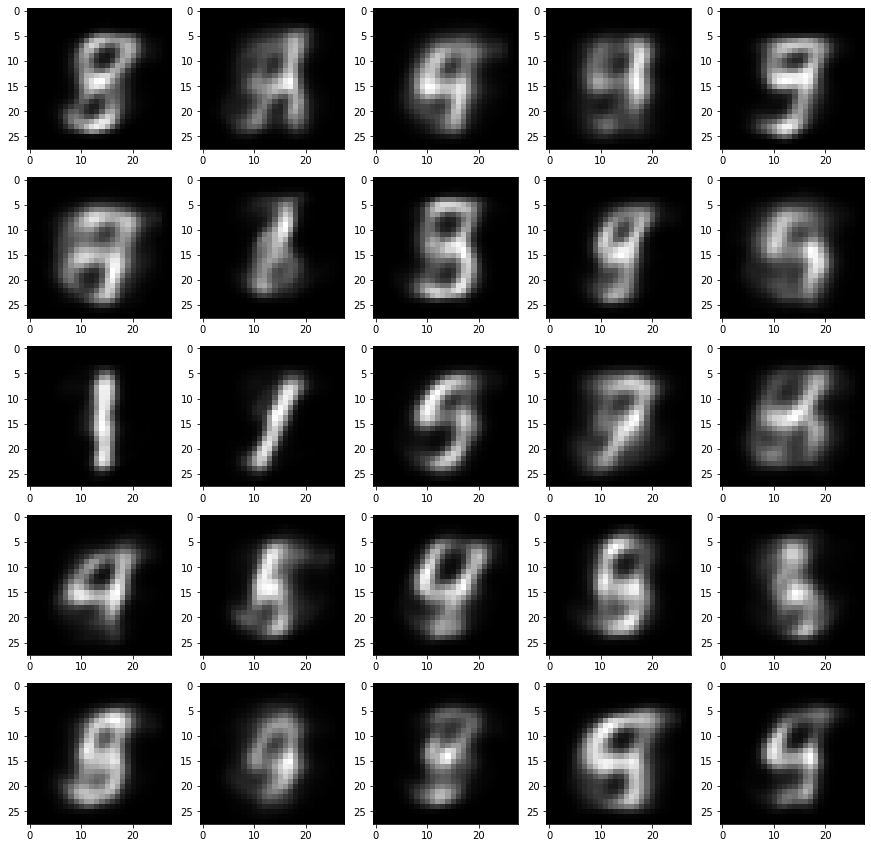

In [90]:
generate_images(vae_pyro)